# Analysis of segmented HP1 phase droplets

This notebook builds out our analysis method for the segmented bright field images of HP1$\alpha$ droplets developed [here](path_to_part_1).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

from skimage.external.tifffile import imread, imsave
from skimage.feature import canny
from skimage.measure import regionprops,find_contours
from skimage.draw import circle
from skimage.morphology import watershed

from scipy import ndimage as ndi
from scipy import fftpack
from scipy.ndimage.filters import convolve
from scipy import integrate
from scipy.ndimage import distance_transform_edt

from smtools.point_fitting import find_maxima

import random

import os
import time
#-- this is here to suppress the warning about regionprops.coords
#-- switching to r,c coords instead of x,y.
import warnings
warnings.filterwarnings("ignore")

def highpass_fft(Image,radius):
    Image_fft = fftpack.fft2(Image)
    Image_fft2 = Image_fft.copy()
    row, col = Image_fft2.shape

    #-- threshold value
    radius = 150
    for h in range(row):
        val1 = np.sqrt(radius**2 - h**2)
        val2 = np.sqrt(radius**2 - (h-row)**2)
        if np.isnan(val1) and np.isnan(val2):
            Image_fft2[h,:] = 0    
        elif np.isnan(val2) and not np.isnan(val1):
            Image_fft2[h,int(val1):col-int(val1)] = 0
        elif np.isnan(val1) and not np.isnan(val2):
            Image_fft2[h,int(val2):col-int(val2)] = 0
    filtered_Image = fftpack.ifft2(Image_fft2).real
    return(filtered_Image)

def mk_bf_segments(Image, fft_thresh = 150, fft_cutoff = 7,
                   sumrange = 11, thresh_ecc = 0.94, thresh_area = 100, 
                   thresh_ecc_small = .5, thresh_area_small = 10, 
                   thresh_diff = .1):

    Image_new = highpass_fft(Image, fft_thresh)
    mask = np.zeros_like(Image, dtype=bool)
    for i in range(sumrange):
        if i<=fft_cutoff:
            edges = canny(Image, sigma=i)
        else:
            edges = canny(Image_new, sigma=i)
        filled = ndi.binary_fill_holes(edges)
        labels, _ = ndi.label(filled)
        detect = np.zeros_like(Image)
        
        for j in regionprops(labels):
            if j.eccentricity<thresh_ecc and j.area>thresh_area:
                for y,x in j.coords:
                    detect[y,x] = 1
            elif (j.eccentricity<thresh_ecc_small and j.area>thresh_area_small
                  and j.area<=thresh_area):
                for y,x in j.coords:
                    detect[y,x] = 1
        mask = np.logical_or(mask, detect)
        
    #-- Watershed
    mask_labels, _ = ndi.label(mask)
    ws_mask = np.zeros_like(mask_labels)
    bg_mask = np.zeros_like(mask_labels)
    for i in regionprops(mask_labels):
        rp = i.perimeter/(2*np.pi)
        ra = np.sqrt(i.area/np.pi)
        percent_diff = abs(rp-ra)*2/(rp+ra)
        if percent_diff>thresh_diff and i.area>thresh_area:
            for y,x in i.coords:
                ws_mask[y,x] = 1
        else:
            for y,x in i.coords:
                bg_mask[y,x] = 1

    distance = distance_transform_edt(mask)
    maxima = np.zeros_like(distance)        
    for x,y in find_maxima(distance, 7, threshold_method = "threshold_mean"):
        maxima[y,x] = 1
    labels, _ = ndi.label(maxima) 
    labels_ws = watershed(-distance, labels, mask=ws_mask, 
                          watershed_line=True)
    labels_bg, _ = ndi.label(bg_mask) 
    labeled_output = np.zeros_like(mask_labels)
    label = 1
    #filtering
    for i in regionprops(labels_ws):
        if i.area >1 and i.eccentricity<thresh_ecc_small:
            for y,x in i.coords:
                labeled_output[y,x] = label
            label+=1
    for i in regionprops(labels_bg):
        for y,x in i.coords:
            labeled_output[y,x] = label
        label+=1
    return labeled_output

def bootstrapSurvival(lifetimes, stepsize = 1, 
                      CI = 0.5, samples = 200):
    
    bins = np.linspace(0,max(lifetimes)/stepsize,max(lifetimes)/stepsize)
    n,_ = np.histogram(lifetimes, bins, normed=True)
    measured_cdf = np.cumsum(n)
    measured_cdf[:] = [1.0-x for x in measured_cdf]
    
    tmp_survival = []
    for i in range(samples):
        n,_ = np.histogram(np.random.choice(lifetimes, len(lifetimes)), 
                           bins, normed=True)
        cdf = np.cumsum(n)
        cdf[:] = [1.0-x for x in cdf]
        tmp_survival.append(cdf)
    
    top_err, bot_err = [],[]   
    for i in range(len(bins[:-1])):
        data = [row[i] for row in tmp_survival]
        data.sort()
        top_err.append(data[int(CI*len(data))])
        bot_err.append(data[int((1.-CI)*len(data))])
        
    return bins[:-1],measured_cdf, top_err, bot_err

Much of the data reported in our publication uses the developed method for segmenting the brightfield images of HP1$\alpha$ droplets. From there, we determine the expectation value of the radius of condnesates in the following way.

* Segement the image
* Determine the complementary cumulative radius distribution function, or the exceedance probability
* Integrate the exceedence probability to determine the expectatino value.


In [3]:
imlist = [imread("test_images/"+i) for i in os.listdir("test_images/")]

radii = []
for im in range(len(imlist)):
    im_seg = mk_bf_segments(imlist[im])
    labels, _ = ndi.label(im_seg) 
    for label in regionprops(labels):
        radii.append(label.equivalent_diameter/2.)


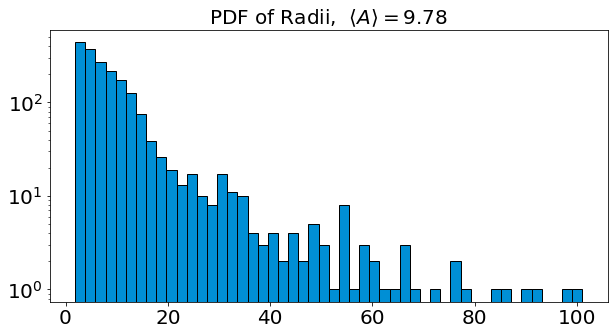

In [4]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(111)
ax1.set_title(r"PDF of Radii,  $\langle A \rangle = $"+"{:.2f}".format(np.mean(radii)), fontsize = 20)
ax1.hist(radii, 50, log=True, ec = "k", fc = "#008fd5")


plt.show()

From this distribution we determine the exceedance probability function, because it a more robust statistic. Below is an animation of how this distribution is determined.


![](Combined_plots_small.gif)

To estimate the variance on our determination of the exceedance, we use a bootstrap method to calculate confidence intervals. In the plot below 95% intervals are shown. Finally, the integral of this curve returns the expectation value of the radius, which is the critical value we report in several places within the associated manuscript.


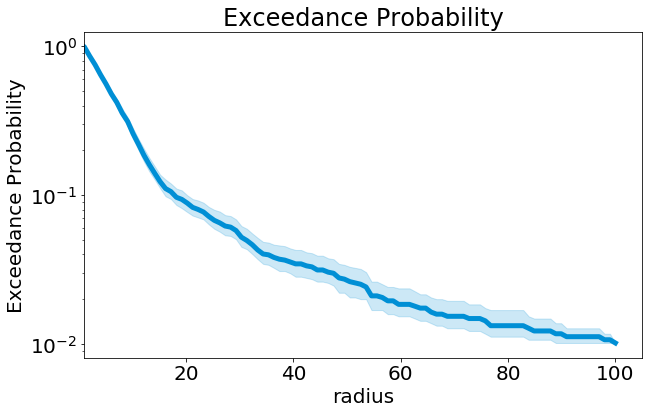

The expectation value of the exceedance probability is:    9.699888327142283


In [6]:
import random

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(111)
x,y,ery_t,ery_b = bootstrapSurvival(radii, samples=200, CI = 0.025)
ax1.semilogy(x,y, linewidth = 5, color = "#008fd5")
ax1.fill_between(x,ery_t, ery_b, alpha = .2, color = "#008fd5")

ax1.set_xlim(1)
ax1.set_title("Exceedance Probability")
ax1.set_xlabel("radius")
ax1.set_ylabel("Exceedance Probability")
plt.show()

print("The expectation value of the exceedance probability is:   ",integrate.simps(y,x))